# SL2P_python

SL2P_python is a python implementation of the Simplified Level 2 Product Prototype Processor (SL2P) in [Weiss and Baret (2016)](https://step.esa.int/docs/extra/ATBD_S2ToolBox_L2B_V1.1.pdf) This implementation corresponds to the algorithm implemented in the [LEAf-Toolbox](https://github.com/rfernand387/LEAF-Toolbox) that corrects for bugs in the implemention of SL2P within the European Space Agency Sentinel 2 Toolbox as documented in [Fernandes et al. 2023](https://www.sciencedirect.com/science/article/pii/S0034425723001517?via%3Dihub).


SL2P estimtates vegetation biophysical variables from Sentinel-2 (S2) MSI L2A multi-spectral images: leaf area index (LAI), fraction canopy cover (FCOVER), fraction of absorbed photosynthetically active radiation (FAPAR), canopy chlorophyll content (CCC) and canopy water content (CWC), in addition to the Albedo and the directional area scattering factor (DASF) not considered in the original SL2P version.

SL2P fCOVER, fAPAR and LAI has been validated using in-situ fiducial reference measurements ([Djamai et al., 2018](https://www.sciencedirect.com/science/article/pii/S0034425719301117?via%3Dihub); [Brown et al., 2021](https://www.sciencedirect.com/science/article/pii/S0924271621000617); [Fernandes et al. 2023](https://www.sciencedirect.com/science/article/pii/S0034425723001517?via%3Dihub)).  Product users should account for documented uncertainty and may wish to apply documented bias corrections.


The user must specify:
-	the location of S2 to be used (locally saved).
-	the spatial resolution of used data: S2_SR (20-m) or S2_SR_10m (10-m}.
-	the needed vegetation variable: LAI, fAPAR, fCOVER, CCC, CWC, Albedo, or DASF,

The provided solution read the S2 image (SAFE format), prepare the SL2P input data (including data re-sampling, data scaling …) run SL2P, and export products in GeoTIFF product.
The outputted product contains: 

-	Estimates of the selected vegetation variable in  [geophysical units](https://github.com/rfernand387/LEAF-Toolbox/wiki/Visualisation-Outputs),
  
-	the uncertainty of estimates in  [geophysical units](https://github.com/rfernand387/LEAF-Toolbox/wiki/Visualisation-Outputs),
  
-	SL2P inputs flag map where a value of 0 indicates valid inputs,
  
-	SL2P outputs flag map where a value of 0 indicates valid outputs.
  

A test dataset (https://drive.google.com/drive/folders/11BGcS0OA4EjGYb9XGfBtNPFpdgw10uWI?usp=drive_link) is provided for a quick test of SL2P_python as well as for comparison of outputs to the corresponding product obtained using the original SL2P version implemented on the Sentinel Application Platform (SNAP). 

Dependencies:
------------
rasterio 1.3.9
matplotlib 3.7.2
datetime 5.4
skimage 0.20.0
tqdm 4.65.0
scipy 1.11.1
pickle 0.0.12

### Import Modules

In [5]:
import SL2P
from tools import read_sentinel2_safe_image
from tools import dictionariesSL2P 
from matplotlib import pyplot as plt
import os,numpy
import rasterio

### Initiation

In [6]:
variableName='LAI'
imageCollectionName="S2_SR"
fn = './testdata/S2B_MSIL2A_20230831T155829_N0509_R097_T18TVR_20230831T203613.SAFE' 

In [7]:
#### Input data Control ***-
if variableName not in dictionariesSL2P.make_net_options().keys():
    raise ValueError(('Supported vegetation valiables: %s'%(dictionariesSL2P.make_net_options().keys())))
if imageCollectionName not in dictionariesSL2P.make_net_options()[variableName].keys():
    raise ValueError(('Supported EO datasets: %s'%(dictionariesSL2P.make_net_options()[variableName].keys())))  
    
### Determine data resolution
RES=dictionariesSL2P.define_input_resolution()[imageCollectionName]

### 1- Read Sentinel-2 MSI/L2A image (.SAFE format)

In [8]:
s2=read_sentinel2_safe_image.read_s2(fn,res=RES)

Reading Sentinel-2 image


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s]


### 2- Prepare SL2P input data (11xNxM array): Surface reflectance (8- NxM layers) and acquisition geometry (3- NxM layers )

In [9]:
sl2p_inp=SL2P.prepare_sl2p_inp(s2,variableName,imageCollectionName)

Resample sun and view (sensor) angles
Scaling Sentinel-2 bands
Computing cosSZA, cosVZA and cosRAA
Selecting sl2p input bands
Done!


### 3- Run SL2P

In [10]:
varmap=SL2P.SL2P(sl2p_inp,variableName,imageCollectionName)

Generating sl2p input data flag
Run SL2P...
SL2P start: 2024-01-30 10:01:14.373845
SL2P end: 2024-01-30 10:01:30.249992
Generating sl2p output product flag
Done


### Export Sl2P product

In [11]:
ofn=fn.replace('.SAFE',variableName+'.tif')
profile=s2['profile']
profile.update({'count':4,'dtype':'float32','driver':'GTiff'}) 
with rasterio.open(ofn,'w',**profile) as dst:
    dst.write(varmap[variableName],1)
    dst.write(varmap[variableName+'_uncertainty'],2)
    dst.write(varmap['sl2p_inputFlag'],3)
    dst.write(varmap['sl2p_outputFlag'],4)

### 4- Show results 

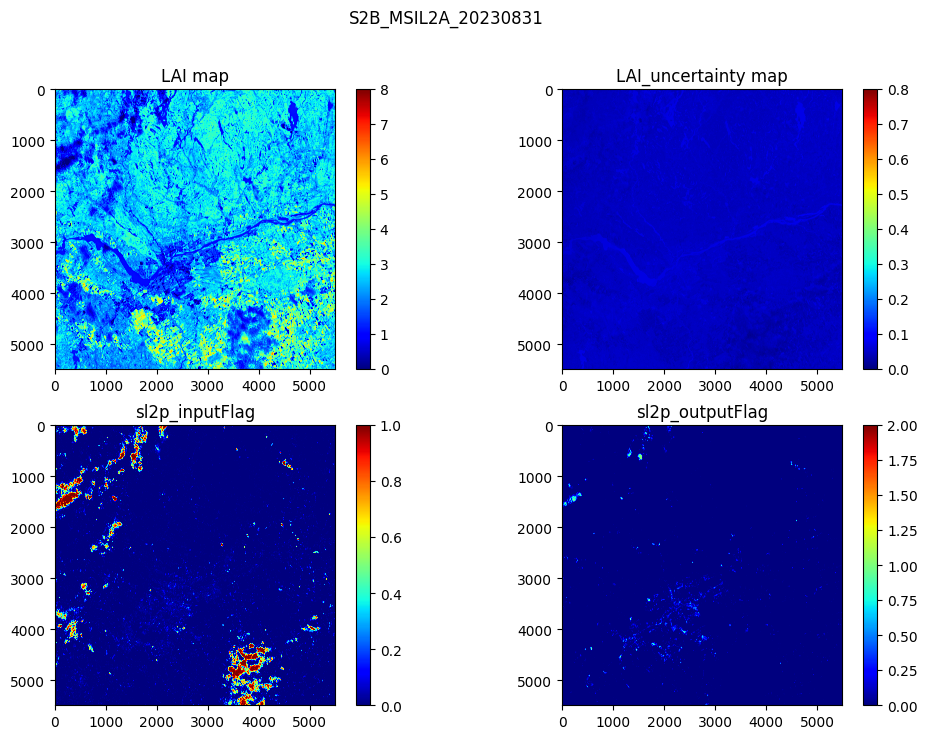

In [12]:
maxvar=dictionariesSL2P.make_outputParams()[variableName]['outputMax']

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(12,8))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName],vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(varmap[variableName+'_uncertainty'],vmin=0,vmax=maxvar/10,cmap='jet')
ax2.set_title(variableName+'_uncertainty'+' map')
fig.colorbar(im2, ax=ax2, orientation='vertical')

im3 = ax3.imshow(varmap['sl2p_inputFlag'],vmin=0,vmax=1,cmap='jet')
ax3.set_title('sl2p_inputFlag')
fig.colorbar(im3, ax=ax3, orientation='vertical')

im4 = ax4.imshow(varmap['sl2p_outputFlag'],vmin=0,vmax=2,cmap='jet')
ax4.set_title('sl2p_outputFlag')
fig.colorbar(im4, ax=ax4, orientation='vertical')

### 5- Mask cloud, shadow, water ...

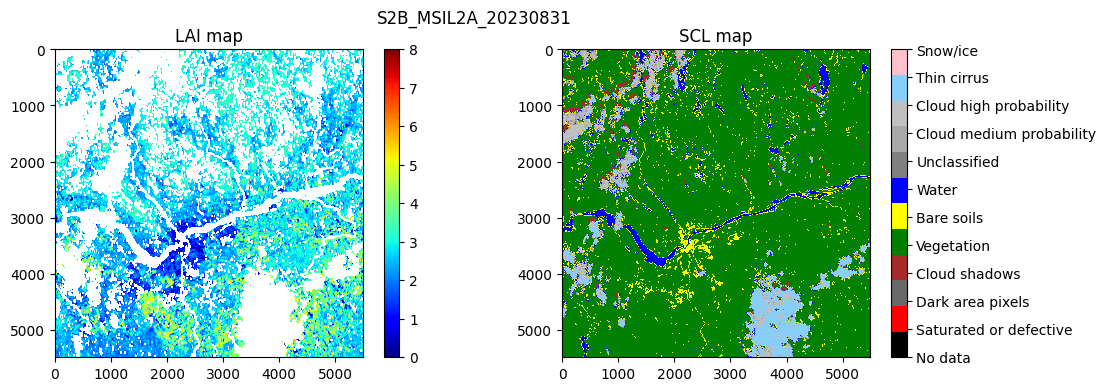

In [14]:
# Mask cloud, shadow, ....
from matplotlib.colors import ListedColormap
cmap =  ListedColormap(["black","red","dimgray","brown","green","yellow","Blue","gray","darkgray","silver","lightskyblue","pink"])
mask=numpy.where((s2['SCL']==4) | (s2['SCL']==5), 1, numpy.nan)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName]*mask,vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map')
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(s2['SCL'],vmin=0,vmax=11,cmap=cmap)
ax2.set_title('SCL map')
cbar=fig.colorbar(im2, ax=ax2, ticks=numpy.linspace(0, 11, 12),orientation='vertical')
cbar.ax.set_yticklabels(['No data','Saturated or defective','Dark area pixels','Cloud shadows','Vegetation','Bare soils','Water','Unclassified','Cloud medium probability','Cloud high probability','Thin cirrus','Snow/ice']);

### 6- Comparaison with SL2P-SNAP version product  

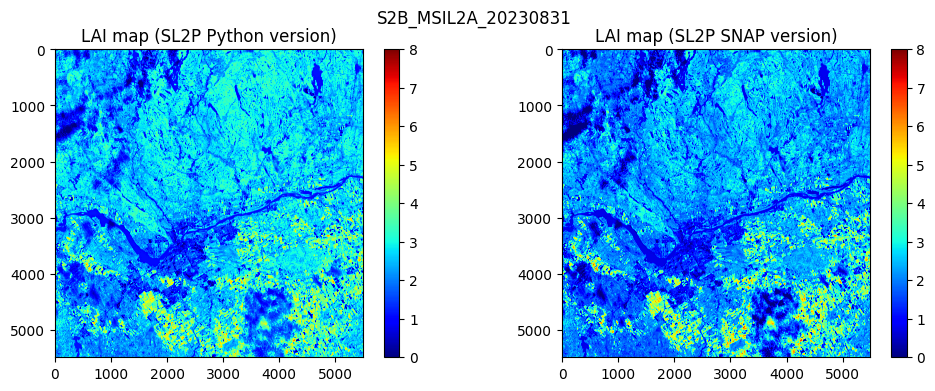

In [15]:
import rasterio

ref_path='./testdata/sl2p_snap_products/'
ref_fn=[ff for ff in os.listdir(ref_path) if variableName in ff][0]

with rasterio.open(ref_path+ref_fn) as rio:
    snap_sl2p_product=rio.read(1)
    
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(os.path.split(fn)[-1][:19])

im1 = ax1.imshow(varmap[variableName],vmin=0,vmax=maxvar,cmap='jet')
ax1.set_title(variableName+' map (SL2P Python version)' )
fig.colorbar(im1, ax=ax1, orientation='vertical')

im2 = ax2.imshow(snap_sl2p_product,vmin=0,vmax=maxvar,cmap='jet')
ax2.set_title(variableName+' map (SL2P SNAP version)')
fig.colorbar(im2, ax=ax2, orientation='vertical')